# Analysis of Survey Data III: Proof Of Concept Analyses

In here I will use the story factors extracted through  [an extensive EFA](step_2_scale_construction_efa.ipynb) to perform a couple of proof of concept analyses. The goal is to show how the story factors could be used to answer research questions about the influece of various model architectures or hyperparameters on the quality and nature of the generated stories.

## Import Packages And Configure Settings


In [17]:
# Base modules
import pandas as pd
import numpy as np
import itertools

# Visualization modules
import matplotlib.pyplot as plt
import seaborn as sns

# Data analysis modules
import pingouin as pg
import scipy.stats as stats
# sklearn
from sklearn.model_selection import cross_validate, KFold
from sklearn.linear_model import LinearRegression as linreg
# statsmodels
import statsmodels.api as sm
from statsmodels.formula.api import ols
from statsmodels.stats.multitest import fdrcorrection

# matplotlib settings
%matplotlib inline
plt.style.use('fivethirtyeight')

import anova_utils


## Read in and prepare the dataset


In [18]:
# Survey response data
aiss = pd.read_csv("data/aiss_factors.csv",
                   index_col=0)
aiss.head(3)


,response_id,story_id,prompt_label,preset_label,sample,full_story,word_count,coh,crea_qual,pace,avoid_rep,con_char
0,R_3LZPTbqxmeWvp7w,GEN_HF_6,High Fantasy,Genesis,Community,The sun was high in the sky when they arrived ...,1105,0.392899,1.088292,0.350588,1.755852,0.573878
1,R_3CCMkj9T7UgOtgP,ALL_HR_3,Historical Romance,All-Nighter,Community,"The first time he saw her, the sight of her wa...",1239,-0.582794,-1.296400,1.513246,0.872302,0.536608
2,R_3PBKFhmDXlAQNO6,ALL_HOR_2,Horror,All-Nighter,Community,"I woke up to hear knocking on glass. At first,...",1134,-1.572414,-0.893623,1.466000,0.421896,-0.804009


## Analyze Impact of Preset & Prompt


### First Visualizations of Story Factors by Preset & Prompt

<Figure size 1000x1000 with 0 Axes>

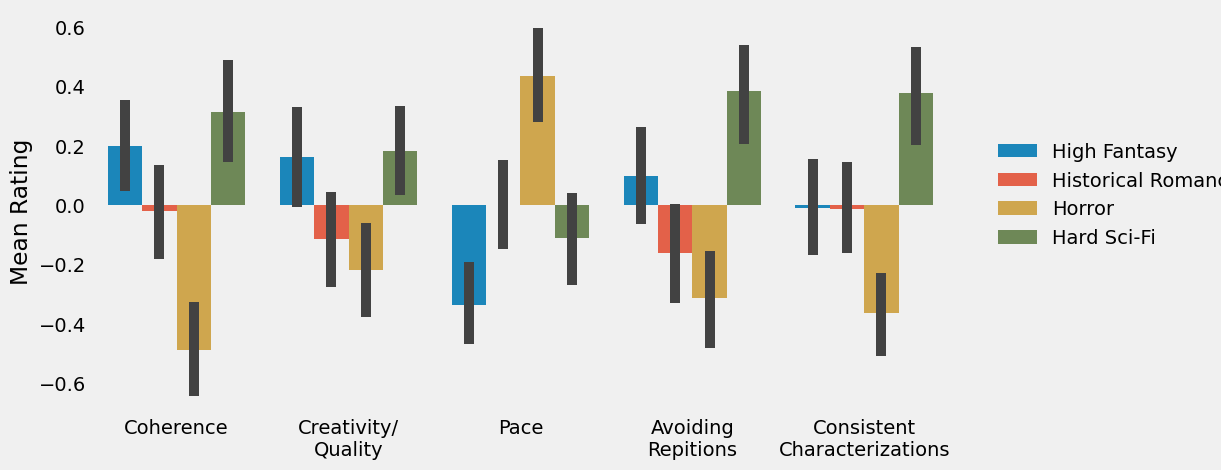

In [19]:
plt.figure(figsize=(10, 10))

tidy = aiss[["response_id", "prompt_label",
             "coh", "crea_qual", "pace", "avoid_rep", "con_char"]
            ].melt(id_vars=['response_id', "prompt_label"])

ax = sns.catplot(data=tidy,
                 kind="bar",
                 y="value", x="variable", hue="prompt_label",
                 errorbar = ("ci", 90), height=5, aspect=2)

ax.set_axis_labels("", "Mean Rating")
ax.set_xticklabels(["Coherence", "Creativity/\nQuality", "Pace", "Avoiding\nRepitions", "Consistent\nCharacterizations"])
plt.grid(False)
ax._legend.set_title(None)
ax._legend.set_bbox_to_anchor([1.0, 0.55])
plt.show()


We can already see that there are clear differences between prompts with different genres. Fantasy and scifi seems to be doing better overall, which is maybe not so surprising given that it probably has a strong focus in the fine-tune data.

The model seemed to have struggled with the horror prompt: Stories were less coherent, lower in creativity/quality, had more repitions and inconsistent characters. I will analyze the precise influence of the prompts in more detail later.

<Figure size 1000x1000 with 0 Axes>

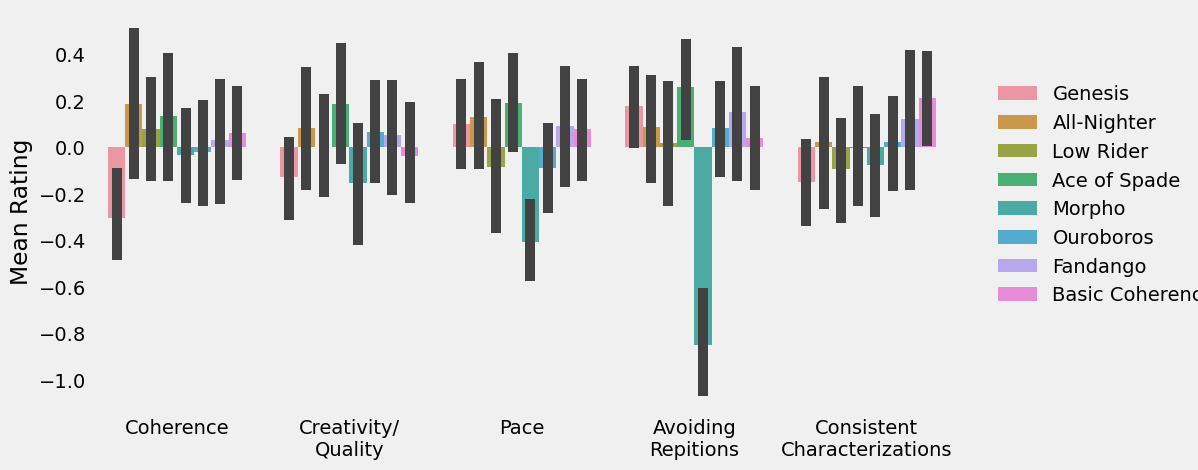

In [20]:
plt.figure(figsize=(10, 10))

tidy = aiss[["response_id", "preset_label",
             "coh", "crea_qual", "pace", "avoid_rep", "con_char"]
            ].melt(id_vars=['response_id', "preset_label"])

ax = sns.catplot(data=tidy,
                 kind="bar",
                 y="value", x="variable", hue="preset_label",
                 errorbar = ("ci", 90), height=5, aspect=2)

ax.set_axis_labels("", "Mean Rating")
ax.set_xticklabels(["Coherence", "Creativity/\nQuality", "Pace", "Avoiding\nRepitions", "Consistent\nCharacterizations"])
plt.grid(False)
ax._legend.set_title(None)
ax._legend.set_bbox_to_anchor([1.0, 0.55])

plt.show()


In general, most of NAI's predefined generation settings (called "presets" in NAI) seem to not differ too much in their story factors. A clear exception however, is the "Morpho" preset, with a lower pace and much more repititions that the other presets.

Furthermore, it looks like the "Genesis" preset might score somewhat lower on Coherence. Given that Genesis is NAI's default preset for this model, this would be a notable finding.

The influence of the presets on the story factors will also be analyzed in more detail later.

### Use Word Count as a Control Variable?


The rated stories differed in length:

In [21]:
aiss['word_count'].describe()

count     323.000000
mean     1175.173375
std       117.123578
min       744.000000
25%      1115.000000
50%      1185.000000
75%      1243.000000
max      1499.000000
Name: word_count, dtype: float64

Some story factors might differ by word count, so it might be worth to control for word count in the analyses. As a first check, I will see if any relationships might non-linear.

<AxesSubplot: xlabel='word_count', ylabel='con_char'>

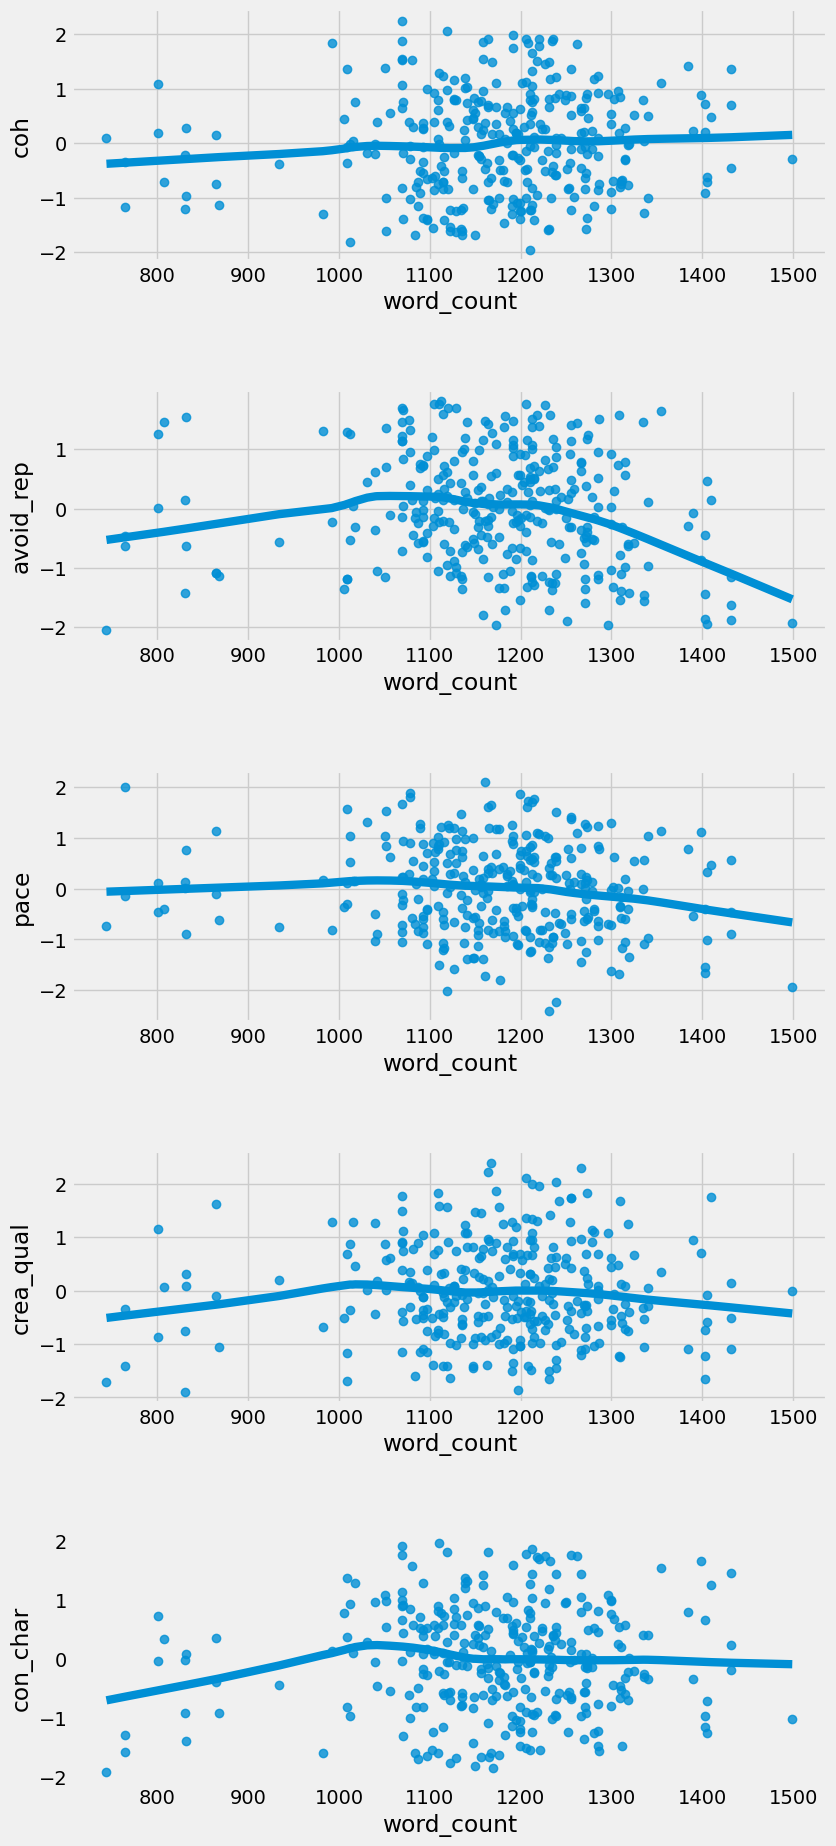

In [22]:
fig, axes = plt.subplots(5, 1, figsize=(10, 20))
fig.tight_layout(pad=5.0)
plt.grid(False)

sns.regplot(data=aiss, y="coh",
            x="word_count", lowess=True, ax=axes[0])
sns.regplot(data=aiss, y="avoid_rep",
            x="word_count", lowess=True, ax=axes[1])
sns.regplot(data=aiss, y="pace",
            x="word_count", lowess=True, ax=axes[2])
sns.regplot(data=aiss, y="crea_qual",
            x="word_count", lowess=True, ax=axes[3])
sns.regplot(data=aiss, y="con_char",
            x="word_count", lowess=True, ax=axes[4])


Some relationships with word count might be quadratic (if there is any relationship at all). I will check for the most appropriate polynomial terms with k-fold cross validation.

In [23]:
# Setting up k-fold cross validation

kf = KFold(10, shuffle=True, random_state=42)

# Defining predictors for models
aiss["words_cent"] = aiss["word_count"].apply(
    lambda x: x-aiss["word_count"].mean())  # centering

aiss["words_cent2"] = aiss["words_cent"]*aiss["words_cent"]
aiss["words_cent3"] = aiss["words_cent"]**3
#aiss["words_cent**4"] = aiss["words_cent"]**4
#aiss["words_cent**5"] = aiss["words_cent"]**5

lin_model = linreg()

pred_li = [("linear", "words_cent"), ("quadratic", "words_cent2"),
           ("cubic", "words_cent3")]
#("quartic", "words_cent**4"),
# ("quintic", "words_cent**5")]
outcome_li = ["coh", "crea_qual", "pace", "avoid_rep", "con_char"]


for outcome in outcome_li:
    y = aiss[outcome]
    current_preds_col = []

    for pred in pred_li:
        current_preds_col.append(pred[1])
        x = aiss.loc[:, current_preds_col]

        current_model_name = pred[0]

        cross_val = cross_validate(lin_model, x, y,
                                   scoring=["neg_mean_squared_error", "r2"], cv=kf)

        neg_mses = cross_val["test_neg_mean_squared_error"]
        r_squares = cross_val["test_r2"]
        avg_rmse = np.mean((neg_mses*-1)**0.5)
        avg_r_sq = np.mean(r_squares)
        print("Model performance for {} model predicting {}:".format(
            current_model_name, outcome))
        print("r-square: {:.4f}    RMSE: {:.4f}".format(avg_r_sq, avg_rmse))
    print("")

# word count is completly irrelevant to story ratings...
# if it stays this way I could just run a MANOVA


Model performance for linear model predicting coh:
r-square: -0.0210    RMSE: 0.9277
Model performance for quadratic model predicting coh:
r-square: -0.0270    RMSE: 0.9302
Model performance for cubic model predicting coh:
r-square: -0.0333    RMSE: 0.9330

Model performance for linear model predicting crea_qual:
r-square: -0.0526    RMSE: 0.9049
Model performance for quadratic model predicting crea_qual:
r-square: -0.0497    RMSE: 0.9032
Model performance for cubic model predicting crea_qual:
r-square: -0.0518    RMSE: 0.9041

Model performance for linear model predicting pace:
r-square: -0.0397    RMSE: 0.8675
Model performance for quadratic model predicting pace:
r-square: -0.0358    RMSE: 0.8661
Model performance for cubic model predicting pace:
r-square: -0.0387    RMSE: 0.8672

Model performance for linear model predicting avoid_rep:
r-square: 0.0052    RMSE: 0.9265
Model performance for quadratic model predicting avoid_rep:
r-square: 0.0512    RMSE: 0.9021
Model performance for 

For most factors, word count does not seem to matter much at all.

The only excpetion is the "avoid repetition" factor, which seems to be negatively related to low and high word count. Not so sure about the low word count, but the high word count makes sense: The longer the story, the more likely it is that the model will repeat itself.

Just to be sure, will include a quadratic term for word count in the analyses.

## ANCOVA Model Diagnostics


#### Outlier Detection
For outlier detection I will be using Tukey's method (maybe better known as boxplot-method). This method considers data points that are more than 1.5 times the interquartile range (IQR) away from the the 1st or 3rd quartile as mild outliers. Points that are more than 3 times the IQR away from the 1st or 3rd quartile are considered extreme outliers.

I will only check the data for extreme outliers, as some mild outliers are to be expected with this sample size.

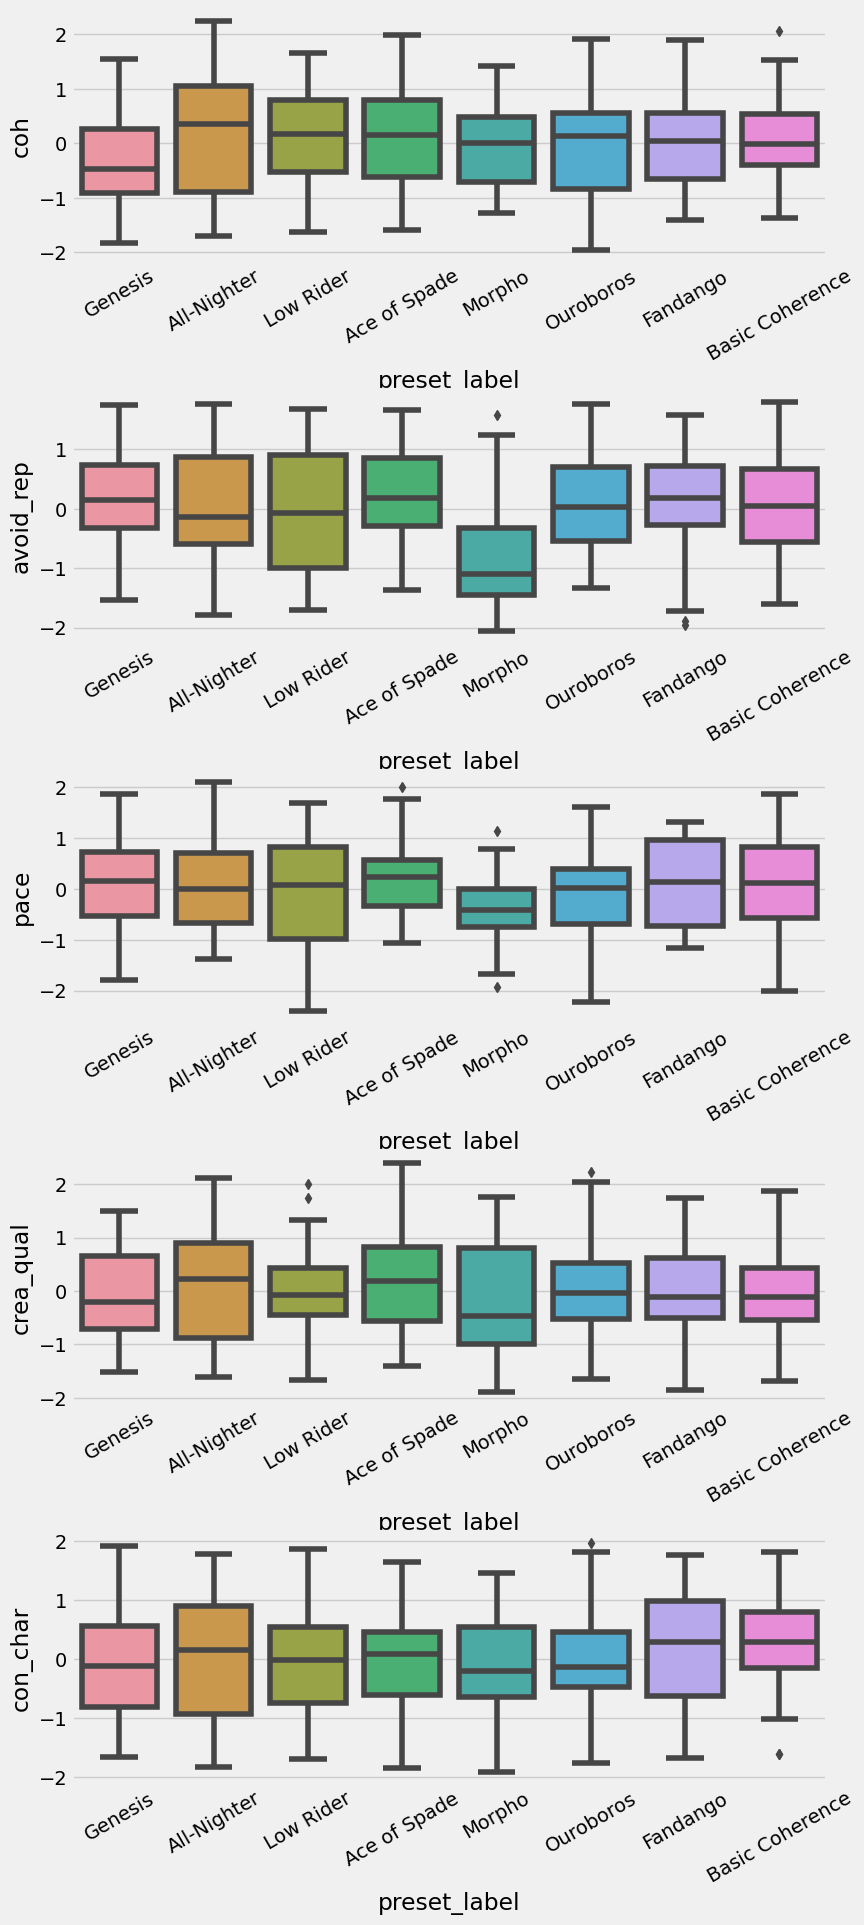

In [24]:
fig, axes = plt.subplots(5, 1, figsize=(10, 20))
fig.tight_layout(pad=5.0)

sns.boxplot(x="preset_label", y="coh", data=aiss, ax=axes[0])
sns.boxplot(x="preset_label", y="avoid_rep", data=aiss, ax=axes[1])
sns.boxplot(x="preset_label", y="pace", data=aiss, ax=axes[2])
sns.boxplot(x="preset_label", y="crea_qual", data=aiss, ax=axes[3])
sns.boxplot(x="preset_label", y="con_char", data=aiss, ax=axes[4])

for ax in axes:
    ax.set_xticklabels(ax.get_xticklabels(), rotation=30)


Most data point outside of the "antennas" can already be visually identified as being only being mild outliers.

Just for illustration, I will still double-check Low Rider for creativity/quality and Basic Coherence for consistent characterisation.

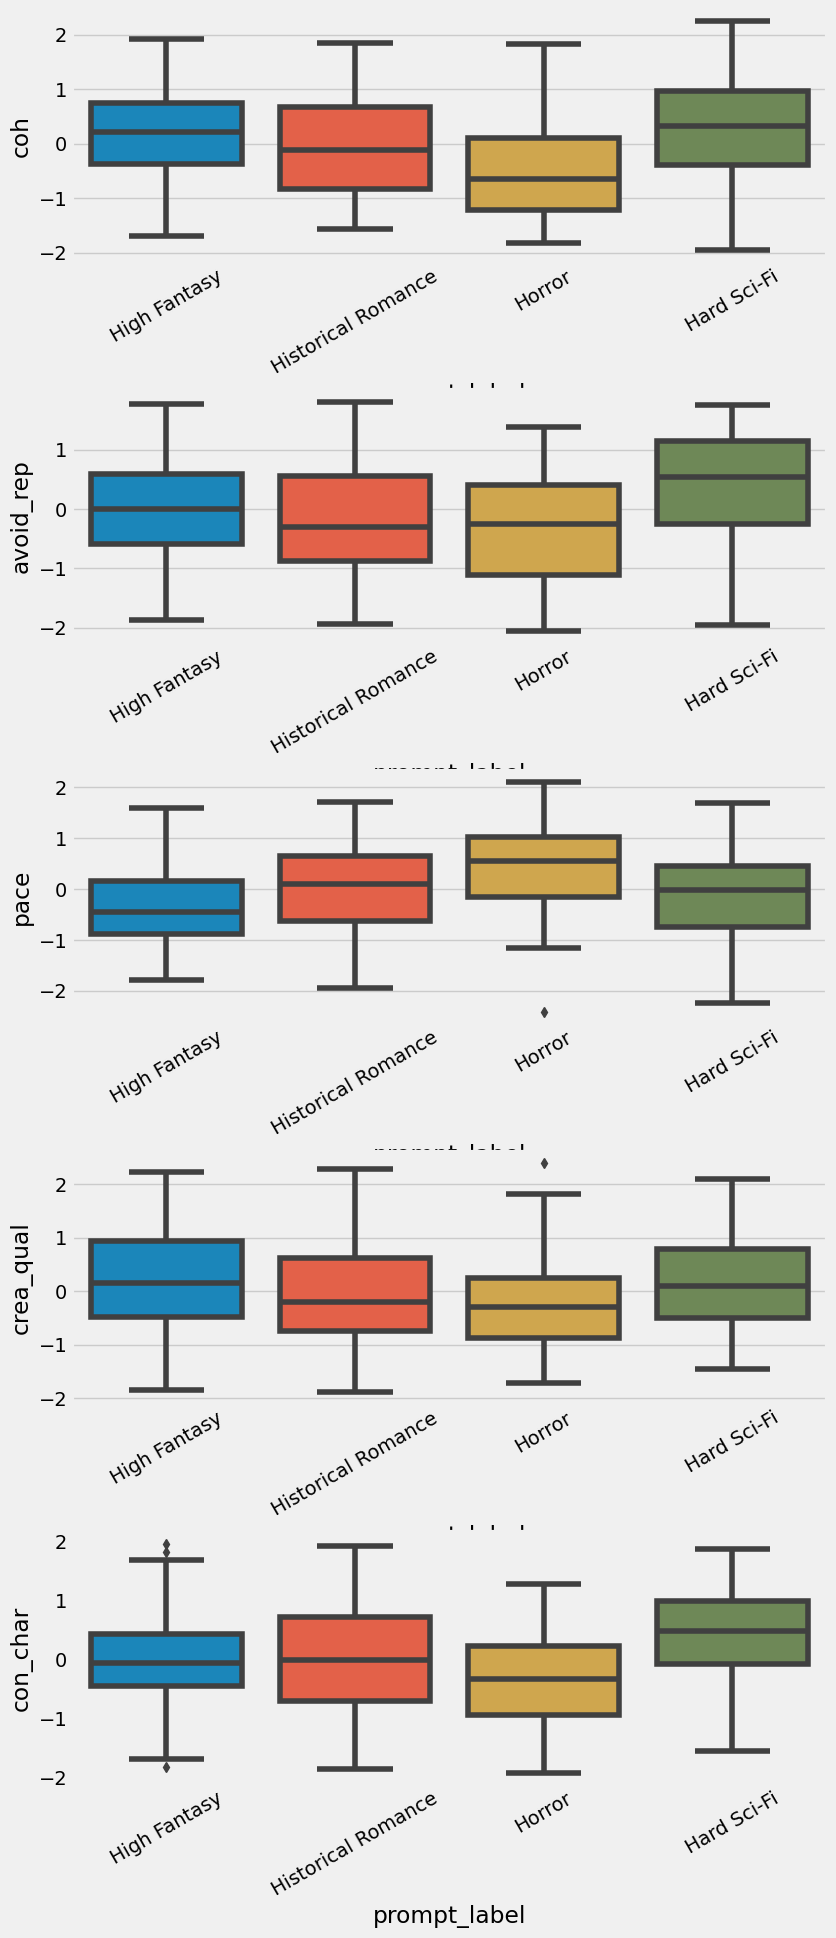

In [25]:
fig, axes = plt.subplots(5, 1, figsize=(10, 20))
fig.tight_layout(pad=5.0)
plt.grid(False)

sns.boxplot(x="prompt_label", y="coh", data=aiss, ax=axes[0])
sns.boxplot(x="prompt_label", y="avoid_rep", data=aiss, ax=axes[1])
sns.boxplot(x="prompt_label", y="pace", data=aiss, ax=axes[2])
sns.boxplot(x="prompt_label", y="crea_qual", data=aiss, ax=axes[3])
sns.boxplot(x="prompt_label", y="con_char", data=aiss, ax=axes[4])

for ax in axes:
    ax.set_xticklabels(ax.get_xticklabels(), rotation=30)


For Horror, there seem to be a couple of mild outliers. Just to be sure, I will double-check them.

In [26]:
# Outliers for Presets

# Outliers creativity
print("\nExterme outliers on crea_qual, Ouroboros preset")
anova_utils.tukey_outliers(aiss[aiss["preset_label"] == "Low Rider"], "crea_qual")

# Outliers consistent characterization
print("\nExterme outliers on pace, Ouroboros")
anova_utils.tukey_outliers(aiss[aiss["preset_label"] ==
                        "Basic Coherence"], "con_char")

# Outliers for Prompts

# Pace
print("\nExterme outliers on tss_avoid rep, Horror prompt")
anova_utils.tukey_outliers(aiss[aiss["prompt_label"] == "Horror"], "avoid_rep")

# Creativity
print("\nExterme outliers on crea_qual, Horror prompt")
anova_utils.tukey_outliers(aiss[aiss["prompt_label"] == "Horror"], "crea_qual")



Exterme outliers on crea_qual, Ouroboros preset
25th Percentile (Q1): -0.44
75th Percentile (Q3): 0.43
IQR: 0.87
Will count cases as outlier with values less than -3.05 or more than 3.04.
With these criteria there are no outlier in the data

Exterme outliers on pace, Ouroboros
25th Percentile (Q1): -0.16
75th Percentile (Q3): 0.80
IQR: 0.95
Will count cases as outlier with values less than -3.02 or more than 3.66.
With these criteria there are no outlier in the data

Exterme outliers on tss_avoid rep, Horror prompt
25th Percentile (Q1): -1.10
75th Percentile (Q3): 0.41
IQR: 1.51
Will count cases as outlier with values less than -5.63 or more than 4.94.
With these criteria there are no outlier in the data

Exterme outliers on crea_qual, Horror prompt
25th Percentile (Q1): -0.87
75th Percentile (Q3): 0.24
IQR: 1.12
Will count cases as outlier with values less than -4.22 or more than 3.59.
With these criteria there are no outlier in the data


No noteworthy outliers present in the data.

#### Normality
I will be checking normality with qqplots.

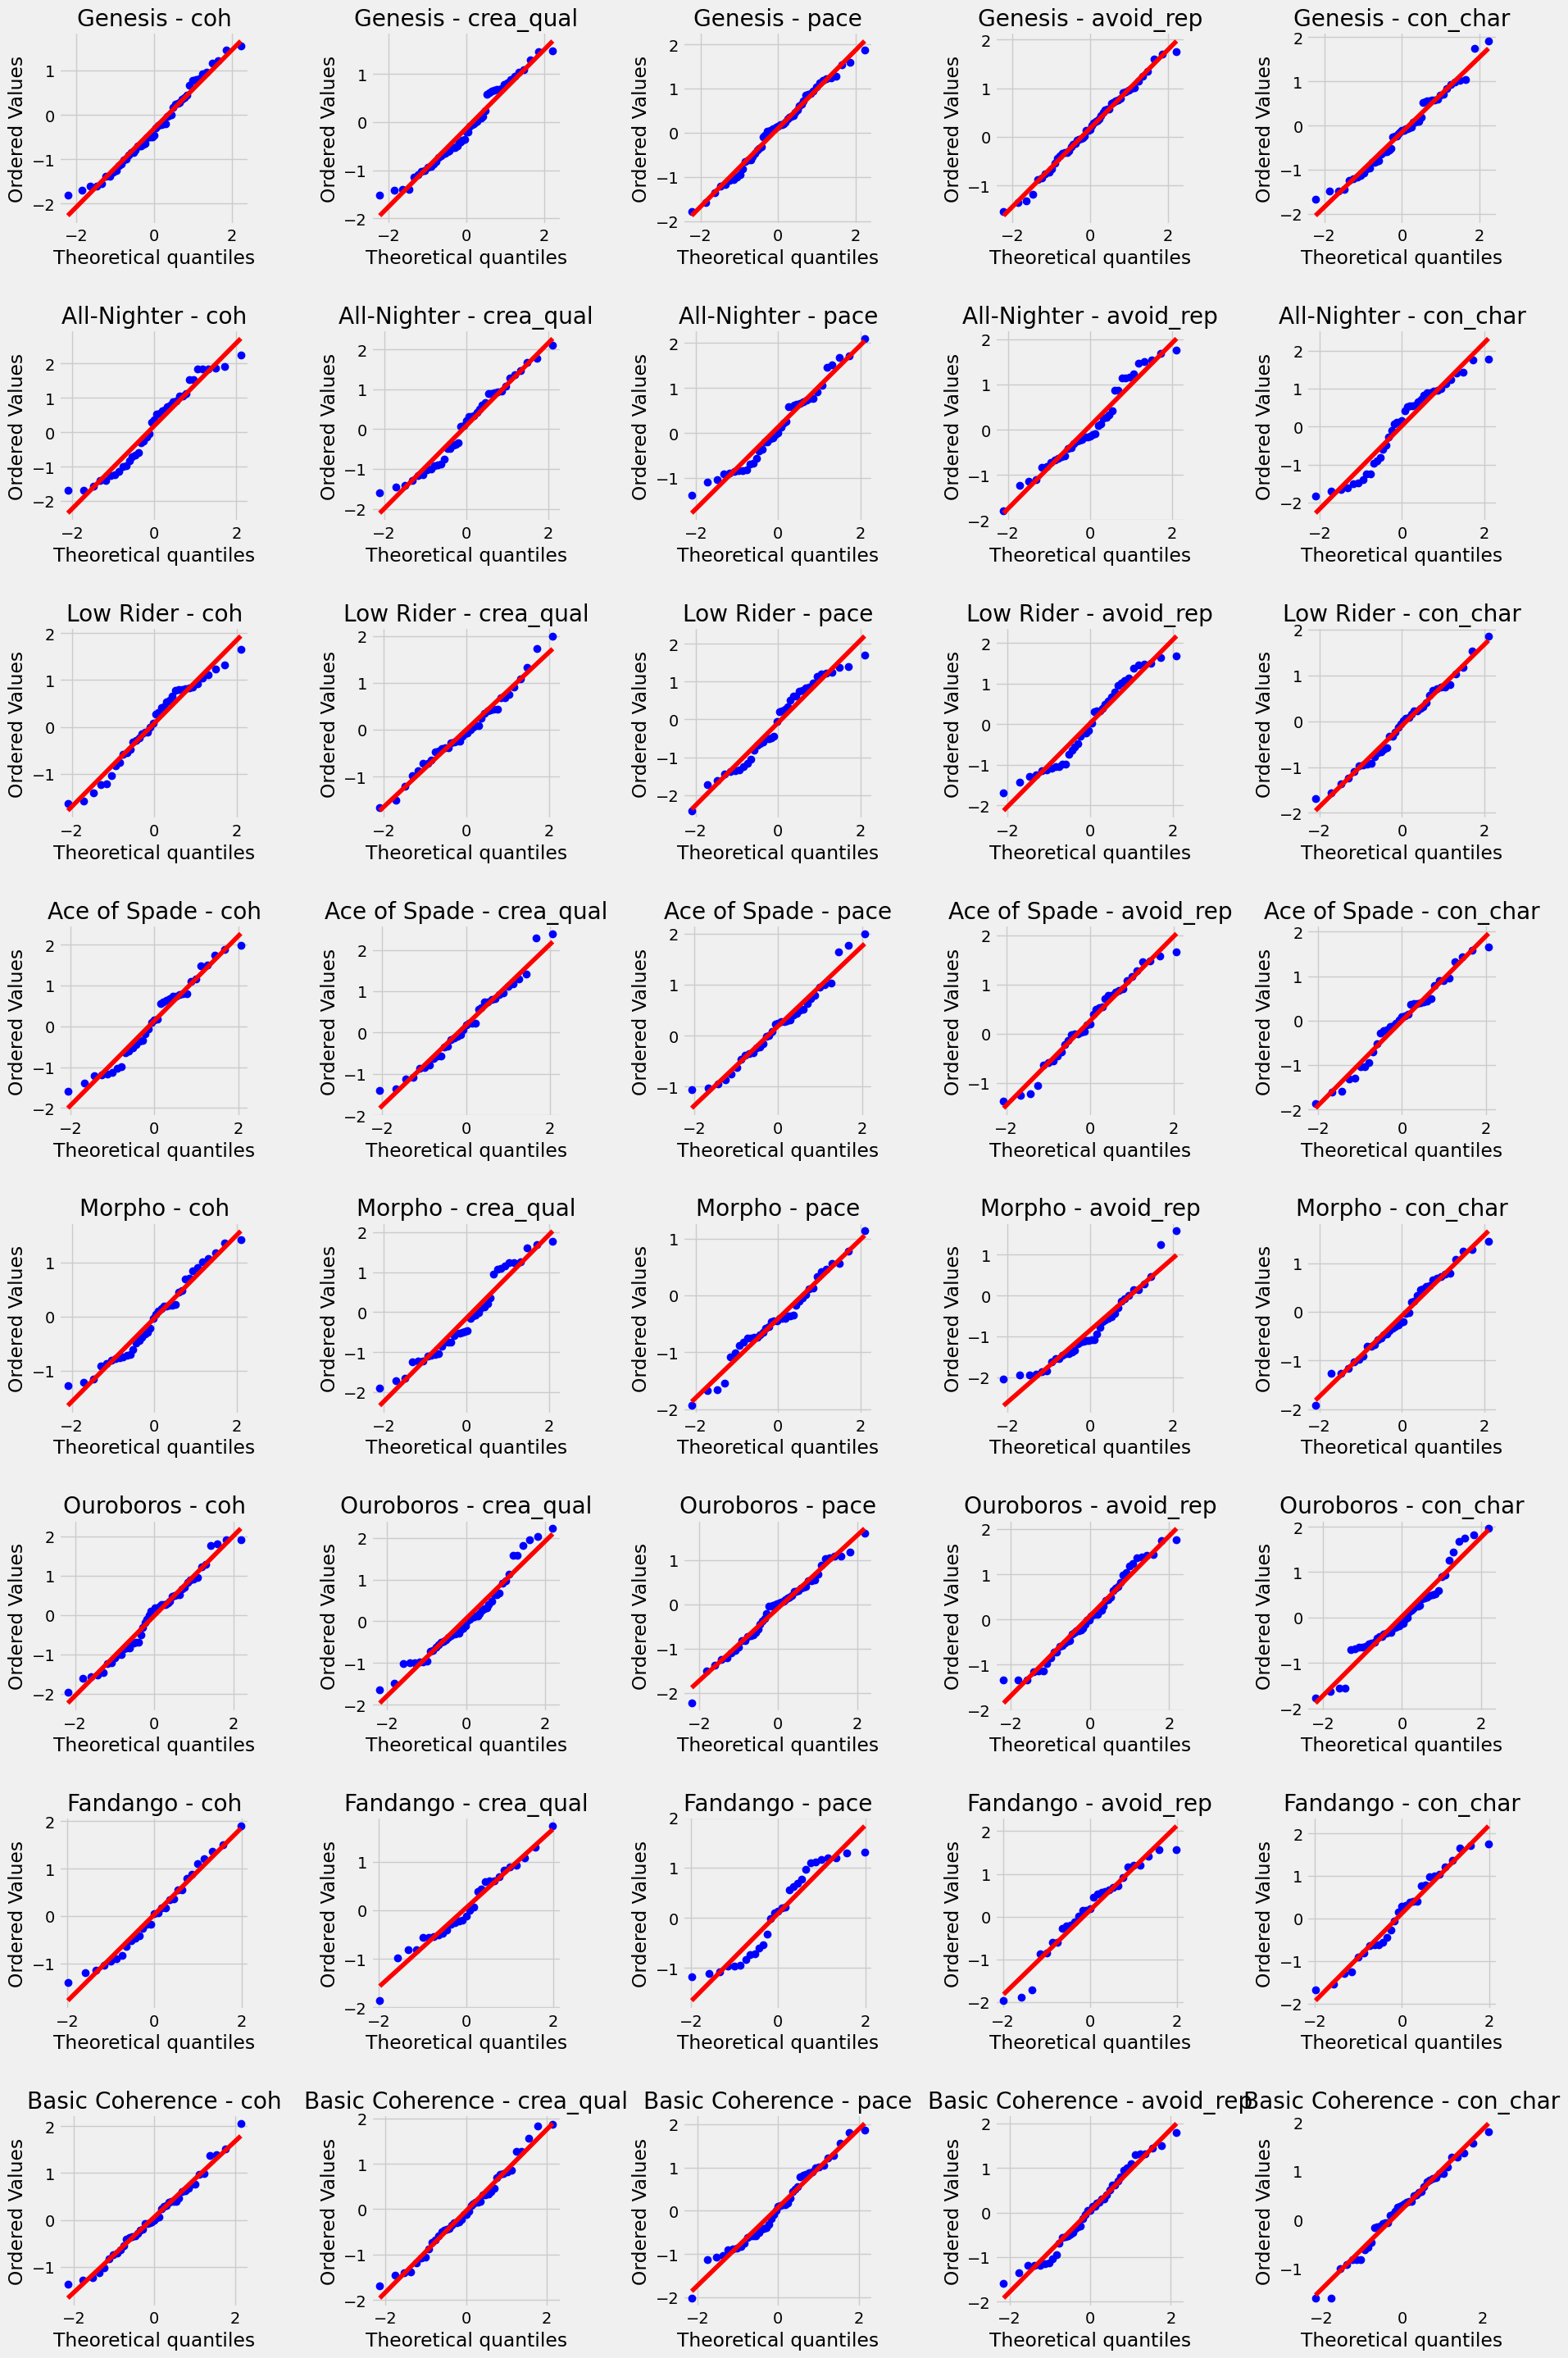

In [27]:
anova_utils.qqs_over_groups_and_vars(aiss, "preset_label", outcome_li, size=(20, 30))


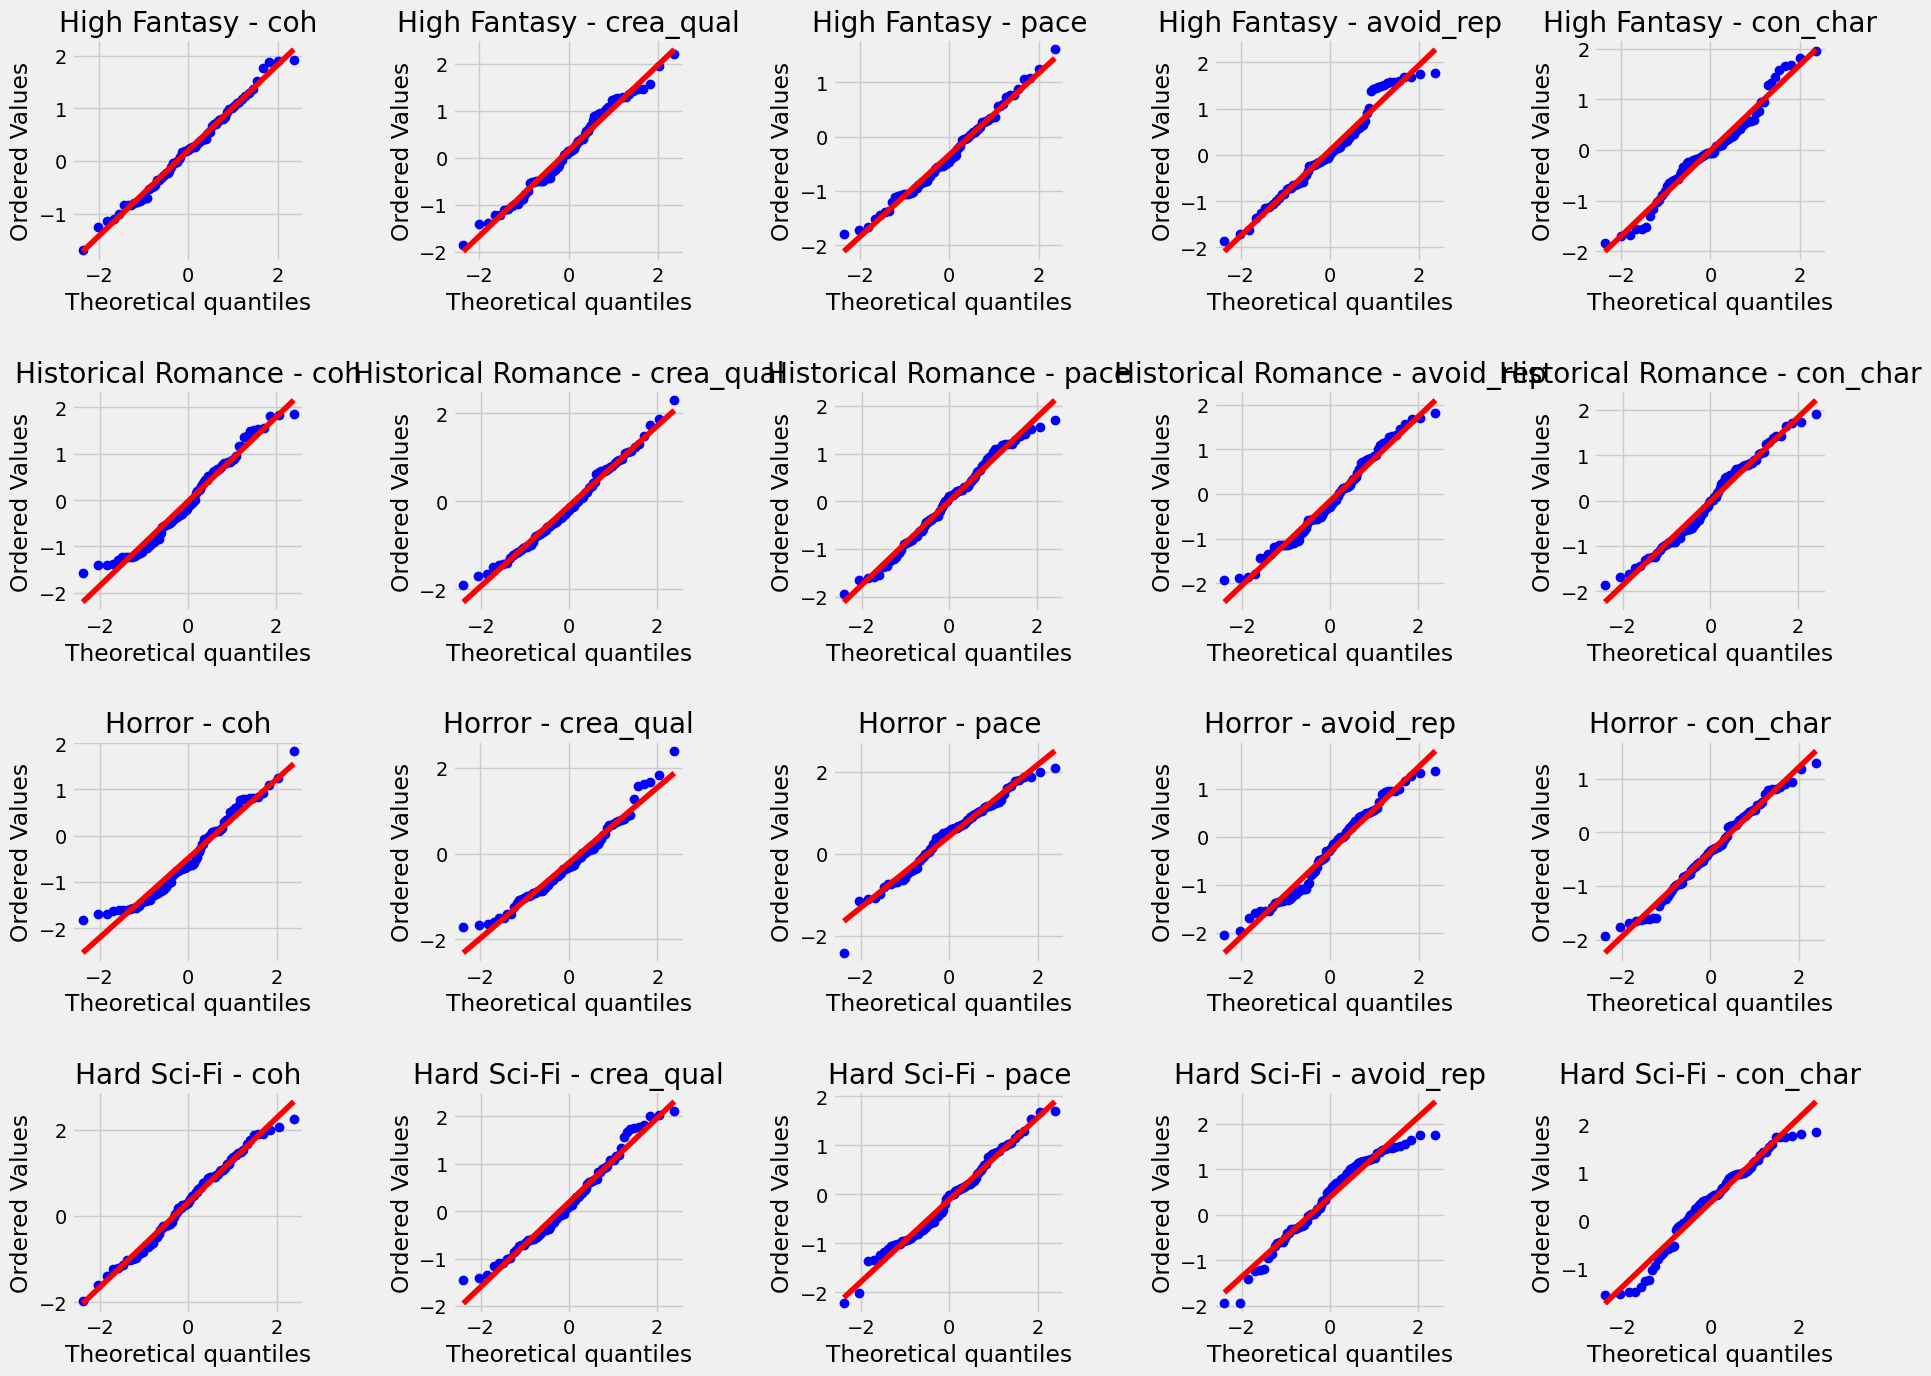

In [28]:
anova_utils.qqs_over_groups_and_vars(aiss, "prompt_label", outcome_li, size=(20, 15))


Looks close enough to normal that it should be fine.

#### Homogeneity of Variance
I will be checking homogeneity of variance with heuristics recommended by [Blanca et al., 2018.](https://link.springer.com/article/10.3758/s13428-017-0918-2).

In [29]:
for outcome in outcome_li:
    print("Checks for {}".format(outcome))
    print("Preset")
    anova_utils.check_homoscedacity(outcome, "preset_label", aiss)
    print("\nPrompt")
    anova_utils.check_homoscedacity(outcome, "prompt_label", aiss)
    print("\n")


Checks for coh
Preset
Smallest variance for Morpho: 0.57
Largest variance for All-Nighter: 1.43
Variance ratio: 2.50
Variance ratio is > 1.5. Now doing additional checks to see if F-test is robust.
Correlation between sample size and variance (pairing) is -0.06.
Pairing is -0.06, so smaller than 0 and larger than or equal to -.5. The coefficient of sample size variation is 0.32, larger than .16. The variance ratio is 2.50, larger than 2. F-test is too liberal (real alpha might be as high as .1 if variance ratio is 9 or smaller).

Prompt
Smallest variance for High Fantasy: 0.64
Largest variance for Hard Sci-Fi: 0.93
Variance ratio: 1.46
Variance ratio is <= 1.5, F-test will be robust.


Checks for crea_qual
Preset
Smallest variance for Fandango: 0.63
Largest variance for Morpho: 1.07
Variance ratio: 1.69
Variance ratio is > 1.5. Now doing additional checks to see if F-test is robust.
Correlation between sample size and variance (pairing) is -0.10.
Pairing is -0.10, coefficient of sample

Heteroscedasticity is present for a couple of story factors. I will be using HC3 standard errors to account for this.

## Running the ANOVA


In [34]:
params_df = pd.DataFrame()

# if heteroscedacity, run with fit(cov_type='HC3') and anova_lm(anova_mod, typ=2, robust='HC3')

for outcome in outcome_li:
    print("\033[1m{}\033[0m".format(outcome))
    ols_formula = outcome + \
        " ~ C(preset_label, Sum) + C(prompt_label, Sum) + C(sample, Treatment(0)) + words_cent +  np.power(words_cent, 2)"
    ols_formula2 = outcome + \
        " ~ C(preset_label, Sum(0)) + C(prompt_label, Sum(0)) + C(sample, Treatment(0)) + words_cent + np.power(words_cent, 2)"
    anova_mod = ols(
        ols_formula, aiss).fit(cov_type='HC3')
    anova_mod2 = ols(
        ols_formula2, aiss).fit(cov_type='HC3')
    print(sm.stats.anova_lm(anova_mod, typ=2, robust='HC3'))
    print(anova_mod.summary(alpha=0.1))

    print("\nDeviation contrasts for\n{}:\tcoef: {:.3f}\tp: {:.3f}"
          .format(anova_mod2.params.index[7], anova_mod2.params[7], anova_mod2.pvalues[7]),
          "\n{}:\tcoef: {:.3f}\tp: {:.3f}"
          .format(anova_mod2.params.index[10], anova_mod2.params[10], anova_mod2.pvalues[10]))
    print("\n")

    params_df[outcome] = anova_mod.params
    params_df[outcome + " p-value"] = anova_mod.pvalues
    params_df[outcome + " 90% CI Lower"] = anova_mod.conf_int(alpha=0.1)[0]

    params_df.loc[anova_mod2.params.index[7], outcome] = anova_mod2.params[7]
    params_df.loc[anova_mod2.params.index[7],
                  outcome + " p-value"] = anova_mod2.pvalues[7]
    params_df.loc[anova_mod2.params.index[7], outcome +
                  " 90% CI Lower"] = anova_mod2.conf_int(alpha=0.1)[0][7]

    params_df.loc[anova_mod2.params.index[10], outcome] = anova_mod2.params[10]
    params_df.loc[anova_mod2.params.index[10],
                  outcome + " p-value"] = anova_mod2.pvalues[10]
    params_df.loc[anova_mod2.params.index[10], outcome +
                  " 90% CI Lower"] = anova_mod2.conf_int(alpha=0.1)[0][10]


coh
                             sum_sq     df          F        PR(>F)
C(preset_label, Sum)       7.555322    7.0   1.381614  2.124154e-01
C(prompt_label, Sum)      27.780187    3.0  11.853478  2.278063e-07
C(sample, Treatment(0))    0.928480    1.0   1.188515  2.764788e-01
words_cent                 0.205706    1.0   0.263317  6.082174e-01
np.power(words_cent, 2)    0.298123    1.0   0.381616  5.371945e-01
Residual                 241.394063  309.0        NaN           NaN
                            OLS Regression Results                            
Dep. Variable:                    coh   R-squared:                       0.139
Model:                            OLS   Adj. R-squared:                  0.103
Method:                 Least Squares   F-statistic:                     4.066
Date:                Tue, 29 Nov 2022   Prob (F-statistic):           3.43e-06
Time:                        10:19:44   Log-Likelihood:                -411.28
No. Observations:                 323   AIC:  

In [ ]:
params_df.index = params_df.index.str.replace(
    r'C\(.*[ST]\.(.*)\]', r'\1', regex=True)

# Transform 90% CI lower bound to 90% CI margin of error
for outcome in outcome_li:
    params_df[outcome + " 90% CI Lower"] = params_df[outcome] - \
        params_df[outcome + " 90% CI Lower"]
params_df.columns = params_df.columns.str.replace(
    "90% CI Lower", "90% CI margin", regex=False)

presets_li = list(aiss["preset_label"].unique())
prompts_li = list(aiss["prompt_label"].unique())

order_index = ["Intercept", "Panel"]
order_index.extend(presets_li)
order_index.extend(prompts_li)

params_df = params_df.reindex(order_index)

cols_order = []

for outcome in outcome_li:
    # no adjustement for p necessary for sample source
    params_df.loc["Panel", outcome +
                  " adj_p"] = params_df.loc["Panel", outcome + " p-value"]
    # adjusted ps for presets
    params_df.loc[presets_li, outcome + " adj_p"] = fdrcorrection(
        params_df.loc[presets_li, outcome + " p-value"], alpha=0.1)[1]
    # adjusted ps for prompts
    params_df.loc[prompts_li, outcome + " adj_p"] = fdrcorrection(
        params_df.loc[prompts_li, outcome + " p-value"], alpha=0.1)[1]

    cols_order.extend([outcome, outcome + " p-value",
                       outcome + " adj_p", outcome + " 90% CI margin"])

params_df = params_df[cols_order]


In [ ]:
params_df


In [ ]:
adj_p_cols = params_df.columns.str.extractall("(.*adj_p)").values.flatten()
mask_sig = (params_df[adj_p_cols] < 0.1).any(axis=1)

params_df[mask_sig]


In [ ]:
aiss["preset_label"].value_counts()


In [ ]:
# labels = ["Coherence", "Creativity", "Avoiding Repitition", "Pace"]

# # create dicts with a key for each preset with an empty list as value for each
# marginal_means_dict = {preset: [] for preset in params_df[1:8].index}
# yerr_dict = {preset: [] for preset in params_df[1:8].index}
# #colors = ["tab:blue", "tab:green", "tab:red", "tab:orange"]

# for preset, outcome in itertools.product(marginal_means_dict.keys(), outcome_li):
#     marginal_means_dict[preset].append(params_df.loc["Intercept", outcome] + params_df.loc[preset, outcome])
#     yerr_dict[preset].append(params_df.loc[preset, outcome + " 90% CI margin"])

# figure = plt.figure(figsize=(10, 5))

# x = np.arange(len(labels)) # label locations
# width = 0.35 # width of bars

# plt.bar(x-width/2, marginal_means_dict["Genesis"], width,
#         yerr = yerr_dict["Genesis"], label = "Genesis", color = "tab:blue")
# plt.bar(x+width/2, marginal_means_dict["Ouroboros"], width,
#         yerr = yerr_dict["Ouroboros"], label = "Ouroboros", color = "tab:orange")


# i = 0
# pos = -0.4
# for outcome in outcome_li:
#     grand_mean = params_df.loc["Intercept", outcome]
#     ax = plt.plot([pos, pos+0.8], [grand_mean, grand_mean], '--', color = "black", alpha = 0.65)
#     if i == 0:
#         ax[0].set_label("Grand Mean (all Presets)")
#     i += 1
#     pos += 1

# plt.ylim(1,5)
# plt.ylabel("Marginal Means (Community Sample)", fontsize = 16)
# plt.xticks(x, labels, fontsize = 16)

# plt.legend(frameon=False, fontsize = 16, loc='upper center', ncol = 3)
# leg = plt.gca().get_legend()
# plt.grid(False)
# #plt.title("Genesis & Low Rider")
# #figure.tight_layout()
# plt.show()

# figure.savefig('graphs/gen_our_1.png', bbox_inches="tight")


## Visualizing the Results


In [ ]:
labels = ["Coherence", "Creativity",
          "Avoiding Repitition", "Pace", "Consistent Characters"]
presets_1 = ["Genesis", "Ouroboros",
             "Basic Coherence", "Low Rider", "All-Nighter"]
presets_2 = ["Morpho", "Ace of Spade", "Fandango"]

preset_to_graph = [presets_1, presets_2]

max_n_presets = max([len(x) for x in preset_to_graph])

fig, axes = plt.subplots(2, 1, figsize=(15, 10))
# fig.tight_layout(pad=5.0)
plt.setp(axes, ylim=(-1, 1))
fig.text(0.02, 0.5, "Marginal Means (Community Sample)",
         va='center', rotation='vertical', fontsize=16)

i = 0
for pre_li in preset_to_graph:

    # create dicts with a key for each outcome with an empty list as value for each
    # values are centered around the mean for the community sample (!)
    # so a value of 0 is exactly the expected mean for the community sample
    marginal_means_dict = {outcome: [] for outcome in outcome_li}
    yerr_dict = {outcome: [] for outcome in outcome_li}

    prod_presets_outcomes = itertools.product(pre_li, outcome_li)

    for preset, outcome in prod_presets_outcomes:
        marginal_means_dict[outcome].append(params_df.loc[preset, outcome])
        yerr_dict[outcome].append(
            params_df.loc[preset, outcome + " 90% CI margin"])

    # Compute difference in length to longest row
    diff_len = max_n_presets - len(pre_li)

    # fill up dictonaries with 0 if less values than the longest row
    if diff_len > 0:
        for outcome in outcome_li:
            marginal_means_dict[outcome].extend([0]*diff_len)
            yerr_dict[outcome].extend([0]*diff_len)

    x = np.arange(len(marginal_means_dict["crea_qual"]))  # label locations
    width = 0.15  # width of bars

    cur_ax = axes[i]
    n_presets = len(pre_li)

    x_labels = pre_li
    x_labels.extend([""]*diff_len)

    cur_ax.set_xticks(x)
    cur_ax.set_xticklabels(x_labels, fontsize=16)

    cur_ax.bar(x-0.3, marginal_means_dict["coh"], width,
               yerr=yerr_dict["coh"], label="Coherence", color="tab:blue")

    cur_ax.bar(x-0.15, marginal_means_dict["crea_qual"], width,
               yerr=yerr_dict["crea_qual"], label="Creativity", color="tab:green")

    cur_ax.bar(x, marginal_means_dict["avoid_rep"], width,
               yerr=yerr_dict["avoid_rep"], label="Avoiding Repetition", color="tab:red")

    cur_ax.bar(x+0.15, marginal_means_dict["pace"], width,
               yerr=yerr_dict["pace"], label="Pace", color="tab:orange")

    cur_ax.bar(x+0.3, marginal_means_dict["con_char"], width,
               yerr=yerr_dict["pace"], label="Consistent Characters", color="tab:purple")

    cur_ax.grid(False)

    i += 1

axes[0].legend(frameon=False, fontsize=16, loc='upper center',
               ncol=3, bbox_to_anchor=(0.6, 1))

# fig.tight_layout()
plt.show()

fig.savefig('graphs/gen_presets_preview.png', bbox_inches="tight")


In [ ]:
# graph for Community vs Panel

# create dicts with a key for pe sample source with an empty list as value for each
marginal_means_dict = {"Community": [], "Panel": []}
yerr_dict = {"Community": [], "Panel": []}

outcome_labels = ["Coherence", "Creativity",
                  "Avoiding\nRepetition", "Pace", "Consistent\nCharacterization"]

for outcome in outcome_li:
    marginal_means_dict["Community"].append(
        params_df.loc["Intercept", outcome])
    yerr_dict["Community"].append(
        params_df.loc["Intercept", outcome + " 90% CI margin"])

    marginal_means_dict["Panel"].append(
        params_df.loc["Intercept", outcome] + params_df.loc["Panel", outcome])
    yerr_dict["Panel"].append(
        params_df.loc["Panel", outcome + " 90% CI margin"])

figure = plt.figure(figsize=(10, 5))

x = np.arange(len(marginal_means_dict["Community"]))  # label locations
width = 0.4  # width of bars

plt.bar(x-0.2, marginal_means_dict["Community"], width,
        yerr=yerr_dict["Community"], label="Nai Users", color="tab:blue")
plt.bar(x+0.2, marginal_means_dict["Panel"], width,
        yerr=yerr_dict["Panel"], label="Panel Participants", color="tab:orange")

plt.ylim(-0.5, 0.5)
plt.ylabel("Marginal Means", fontsize=16)
plt.xticks(x, outcome_labels, fontsize=16)

plt.legend(frameon=False, fontsize=16, loc='upper right')
plt.grid(False)
#plt.title("Genesis & Low Rider")
# figure.tight_layout()
plt.show()

figure.savefig('graphs/community_vs_panel.png', bbox_inches="tight")


In [ ]:
# Create graph for prompts

# create dicts with a key for each outcome with an empty list as value for each
marginal_means_dict = {outcome: [] for outcome in outcome_li}
yerr_dict = {outcome: [] for outcome in outcome_li}

for prompt, outcome in itertools.product(prompts_li, outcome_li):
    marginal_means_dict[outcome].append(params_df.loc[prompt, outcome])
    yerr_dict[outcome].append(
        params_df.loc[prompt, outcome + " 90% CI margin"])

figure = plt.figure(figsize=(10, 5))

x = np.arange(len(marginal_means_dict["crea_qual"]))  # label locations
width = 0.15  # width of bars

plt.bar(x-0.3, marginal_means_dict["coh"], width,
        yerr=yerr_dict["coh"], label="Coherence", color="tab:blue")

plt.bar(x-0.15, marginal_means_dict["crea_qual"], width,
        yerr=yerr_dict["crea_qual"], label="Creativity", color="tab:green")

plt.bar(x, marginal_means_dict["avoid_rep"], width,
        yerr=yerr_dict["avoid_rep"], label="Avoiding Repetition", color="tab:red")

plt.bar(x+0.15, marginal_means_dict["pace"], width,
        yerr=yerr_dict["pace"], label="Pace", color="tab:orange")

plt.bar(x+0.3, marginal_means_dict["con_char"], width,
        yerr=yerr_dict["pace"], label="Consistent Characters", color="tab:purple")

plt.ylim(-1, 1)
plt.ylabel("Marginal Means (Community Sample)", fontsize=16)
plt.xticks(x, prompts_li, fontsize=16)

plt.legend(frameon=False, fontsize=16, loc='upper center',
           ncol=3, bbox_to_anchor=(0.6, 1))
# plt.legend(frameon=False, bbox_to_anchor = (1,.9), fontsize = 16)
plt.grid(False)
#plt.title("Genesis & Low Rider")
# figure.tight_layout()
plt.show()

figure.savefig('graphs/gen_prompts.png', bbox_inches="tight")


# Analyze Consistency of Story Aspects Across Presets & Prompts


In [ ]:
for outcome in outcome_li:
    print(("_"*75) + "\n")
    print("\033[1m{}\033[0m".format(outcome))

    homo_res = pg.homoscedasticity(
        aiss, dv=outcome, group="preset_label", method="levene", alpha=0.1)
    print("Omnibus Test for homoscedasticity across presets")
    print(homo_res.round(3))

    if homo_res.iloc[0, 2] == False:
        print("\nVariances are not equal, doing posthoc tests")
        print(f"Average SD: {aiss[outcome].std():.2f}")
        print("\nPresets with adjusted p-vals < .15 displayed below:")

        posthoc_dict = {}
        for preset in presets_li:
            data_preset = aiss[aiss["preset_label"]
                                     == preset][outcome].to_numpy()
            data_rest = aiss[aiss["preset_label"]
                                   != preset][outcome].to_numpy()
            posthoc_dict[preset] = pg.homoscedasticity(
                [data_preset, data_rest], method="levene", alpha=0.1)

        ps_li = []
        for dv in posthoc_dict:
            ps_li.append(posthoc_dict[dv].iloc[0, 1])
        adj_ps_li = fdrcorrection(ps_li, alpha=0.1)[1]

        i = 0
        for dv in posthoc_dict:
            posthoc_dict[dv].loc["levene",
                                 "sd"] = aiss[aiss["preset_label"] == dv][outcome].std()
            posthoc_dict[dv].loc["levene", "adj_p"] = adj_ps_li[i]
            if posthoc_dict[dv].loc["levene", "adj_p"] < 0.15:
                print(f"\n{dv}")
                print(posthoc_dict[dv].round(3))
            i += 1

    homo_res = pg.homoscedasticity(
        aiss, dv=outcome, group="prompt_label", method="levene", alpha=0.1)
    print("-"*75)
    print("\nOmnibus Test for homoscedasticity across prompts")
    print(f"{homo_res.round(3)}\n")


## Visualize Findings


In [ ]:
def hist_over_groups(df, var, var_name, group_label, groups_li,
                     bins_n=10, xlim=(-3, 3), size=(15, 15),
                     plot_avg=True):
    n_plots = len(groups_li)+1 if plot_avg else len(groups_li)
    fig, axes = plt.subplots(1, n_plots, figsize=size)
    fig.tight_layout(pad=5.0)

    x = 0

    if plot_avg:
        df[var].plot.hist(ax=axes[x], bins=bins_n)
        df[var].plot.kde(ax=axes[x], secondary_y=True)
        axes[x].set_xlim(xlim)
        axes[x].set_title(f"{var_name} - Average")
        plt.grid(False)
        x += 1

    for group in groups_li:
        df_group = df[df[group_label] == group]
        df_group[var].plot.hist(ax=axes[x], bins=bins_n)
        df_group[var].plot.kde(ax=axes[x], secondary_y=True)
        axes[x].set_xlim(xlim)
        axes[x].set_title(f"{var_name} - {group}")
        plt.grid(False)
        x += 1


def box_over_groups(df, var, var_name, group_label, groups_li,
                    ylim=(-3, 3), size=(15, 15),
                    plot_avg=True, save_plot=False):
    n_plots = len(groups_li)+1 if plot_avg else len(groups_li)
    fig, axes = plt.subplots(1, n_plots, figsize=size)
    fig.tight_layout(pad=5.0)

    x = 0

    if plot_avg:
        sns.boxplot(y=df[var], ax=axes[x])
        axes[x].set_ylim(ylim)
        axes[x].set_title(f"{var_name} - Average")
        axes[x].grid(False)
        x += 1

    for group in groups_li:
        df_group = df[df[group_label] == group]
        sns.boxplot(y=df_group[var], ax=axes[x])
        axes[x].set_ylim(ylim)
        axes[x].set_title(f"{var_name} - {group}")
        axes[x].grid(False)
        x += 1

    if save_plot:
        fig.savefig(save_plot, bbox_inches="tight")


In [ ]:
hist_over_groups(aiss, "coh", "Coherence",
                 "preset_label", ["All-Nighter"],
                 size=(15, 5))


In [ ]:
box_over_groups(aiss, "coh", "Coherence",
                "preset_label", ["All-Nighter"],
                size=(15, 6), save_plot="graphs/box_coh.png")


In [ ]:
hist_over_groups(aiss, "pace", "Coherence",
                 "preset_label", ["Low Rider", "Morpho"],
                 size=(15, 5), bins_n=7)


In [ ]:
box_over_groups(aiss, "pace", "Pace",
                "preset_label", ["Low Rider", "Morpho"],
                size=(15, 6), save_plot="graphs/box_pac.png")


In [ ]:
aiss[["coh", "avoid_rep", "pace", "crea_qual", "con_char",
            "crea_qual_4",
            "tss_qua_1", "tss_qua_2"]].corr(method="kendall")


In [ ]:
items_descr[["crea_qual_4", "tss_qua_1", "tss_qua_2", "tss_qua_3",
             "tss_qua_5", "tss_qua_6", "tss_qua_7", "tss_qua_8"]]


In [ ]:
# qual = aiss.groupby('preset_label').mean(
# )[["tss_qua_2", "tss_qua_1", "tss_qua_3"]].sort_values("tss_qua_1")

# figure = plt.figure(figsize=(10, 5))
sns.barplot(x="tss_qua_1", y="preset_label", data=aiss)
#plt.bar(qual.index, qual["tss_qua_1"])
# plt.xticks(rotation=45)


In [ ]:
fig, axes = plt.subplots(7, 2, figsize=(10, 30))
fig.tight_layout(pad=5.0)
plt.grid(False)

sns.regplot(data=aiss, y="coh",
            x="read_consesus", lowess=True, ax=axes[0, 0])
sns.regplot(data=aiss, y="coh",
            x="read_fre", lowess=True, ax=axes[0, 1])
sns.regplot(data=aiss, y="crea_qual",
            x="read_consesus", lowess=True, ax=axes[1, 0])
sns.regplot(data=aiss, y="crea_qual",
            x="read_fre", lowess=True, ax=axes[1, 1])
sns.regplot(data=aiss, y="avoid_rep",
            x="read_consesus", lowess=True, ax=axes[2, 0])
sns.regplot(data=aiss, y="avoid_rep",
            x="read_fre", lowess=True, ax=axes[2, 1])
sns.regplot(data=aiss, y="pace",
            x="read_consesus", lowess=True, ax=axes[3, 0])
sns.regplot(data=aiss, y="pace",
            x="read_fre", lowess=True, ax=axes[3, 1])
sns.regplot(data=aiss, y="con_char",
            x="read_consesus", lowess=True, ax=axes[4, 0])
sns.regplot(data=aiss, y="con_char",
            x="read_fre", lowess=True, ax=axes[4, 1])
sns.regplot(data=aiss, y="tss_qua_1",
            x="read_consesus", lowess=True, ax=axes[5, 0])
sns.regplot(data=aiss, y="tss_qua_1",
            x="read_fre", lowess=True, ax=axes[5, 1])
sns.regplot(data=aiss, y="tss_qua_2",
            x="read_consesus", lowess=True, ax=axes[6, 0])
sns.regplot(data=aiss, y="tss_qua_2",
            x="read_fre", lowess=True, ax=axes[6, 1])
for ax in fig.axes:
    ax.grid(False)

plt.show()


In [ ]:
# Setting up k-fold cross validation

kf = KFold(10, shuffle=True, random_state=42)

# Defining predictors for models
aiss["read_cent"] = aiss["read_consesus"].apply(
    lambda x: x-aiss["read_consesus"].mean())  # centering

aiss["read_cent**2"] = aiss["read_cent"]*aiss["read_cent"]
aiss["read_cent**3"] = aiss["read_cent"]**3
aiss["read_cent**4"] = aiss["read_cent"]**4
aiss["read_cent**5"] = aiss["read_cent"]**5

lin_model = linreg()

pred_li = [("linear", "read_cent"), ("quadratic", "read_cent**2"),
           ("cubic", "read_cent**3"), ("quartic", "read_cent**4"),
           ("quintic", "read_cent**5")]
outcome_li = ["coh", "crea_qual", "avoid_rep",
              "pace", "con_char", "tss_qua_1", "tss_qua_2",
              "tss_sty_5", "tss_sty_5"]


for outcome in outcome_li:
    y = aiss[outcome]
    current_preds_col = []

    for pred in pred_li:
        current_preds_col.append(pred[1])
        x = aiss.loc[:, current_preds_col]

        current_model_name = pred[0]

        cross_val = cross_validate(lin_model, x, y,
                                   scoring=["neg_mean_squared_error", "r2"], cv=kf)

        neg_mses = cross_val["test_neg_mean_squared_error"]
        r_squares = cross_val["test_r2"]
        avg_rmse = np.mean((neg_mses*-1)**0.5)
        avg_r_sq = np.mean(r_squares)
        print("Model performance for {} model predicting {}:".format(
            current_model_name, outcome))
        print("r-square: {:.4f}    RMSE: {:.4f}".format(avg_r_sq, avg_rmse))
    print("")


In [ ]:
outcome_li = ["coh", "crea_qual", "avoid_rep", "pace", "con_char"]

marg_means_df = params_df.loc[["Intercept", "Genesis", "Ouroboros", "Basic Coherence", "Low Rider",
                               "All-Nighter", "Morpho", "Ace of Spade", "Fandango"],
                              ["coh", "crea_qual", "avoid_rep", "pace", "con_char",
                               "coh 90% CI margin", "crea_qual 90% CI margin",
                               "avoid_rep 90% CI margin", "pace 90% CI margin",
                               "con_char 90% CI margin",
                               "coh adj_p", "crea_qual adj_p",
                               "avoid_rep adj_p", "pace adj_p",
                               "con_char adj_p"]].copy()

for outcome in outcome_li:
    marg_means_df.loc[
        ["Genesis", "Ouroboros", "Basic Coherence", "Low Rider", "All-Nighter", "Morpho", "Ace of Spade", "Fandango"], outcome] = marg_means_df.loc[
        ["Genesis", "Ouroboros", "Basic Coherence", "Low Rider", "All-Nighter", "Morpho", "Ace of Spade", "Fandango"], outcome].apply(
        lambda x: marg_means_df.loc["Intercept", outcome]+x)

marg_means_df.rename(index={"Intercept": "Grand Mean"}, inplace=True)
marg_means_df.columns = marg_means_df.columns.str.replace(
    "coh", "Coherence")
marg_means_df.columns = marg_means_df.columns.str.replace(
    "crea_qual", "Creativity")
marg_means_df.columns = marg_means_df.columns.str.replace(
    "avoid_rep", "Avoiding Repitition")
marg_means_df.columns = marg_means_df.columns.str.replace("pace", "Pace")
marg_means_df.columns = marg_means_df.columns.str.replace(
    "con_char", "Consistent Characters")


In [ ]:
marg_means_df


In [ ]:
# Update GSheet from Basileus
gc = gs.oauth()

gsheet = gc.open("Preset Analysis").worksheet("Data")
gsheet_df = gd.get_as_dataframe(gsheet, index_col="Preset")
gsheet_df.update(marg_means_df)
gd.set_with_dataframe(gsheet, gsheet_df, include_index=True)


In [ ]:
mask = ((aiss["preset_label"] == "Morpho") &
        (aiss["coh"] > 2.55) &
        (aiss["avoid_rep"] > 2.21) &
        (aiss["avoid_rep"] < 2.70) &
        (aiss["sample"] == "Community")
        )

aiss[mask]


In [ ]:
print(aiss.loc[35, outcome_li])
print(aiss.loc[35, "full_story"])


In [ ]:
print(aiss.loc[130, outcome_li])
print(aiss.loc[130, "full_story"])


| Preset               | Performance during continuous story generation<br />(Without user intervention)                                                                             |
| :------------------- | ----------------------------------------------------------------------------------------------------------------------------------------------------------- |
| Genesis              | Less coherent than the average                                                                                                                              |
| Basic Coherence      | Narrow range in terms of Coherence.<br />Most outputs are close to average Coherence.<br />(= Low variance)                                                 |
| Ouroboros, Low Rider | Solid - average on all story aspects                                                                                                                        |
| Ace of Spade         | Less repetitions than the average                                                                                                                           |
| All-Nighter          | Wide range of possible outputs in terms of Coherence.<br />You'll get more incoherent outputs, but also more strongly coherent ones.<br />(= High Variance) |
| Morpho               | Major issues with repetitions<br />Low pace (possibly due to repetitions)                                                                                   |
